# **실험 개요**  
심전도 신호에 대한 정상/비정상 판별을 위해 Generative model의 재생성 특성을 활용하였다.  
generative model은 GAN을 사용하였다.  
1) 데이터 로드 및 전처리 작업 수행  
2)GAN 구현 및 학습  
3)GAN 성능 평가  
4)머신러닝 분류기 사용  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

In [ ]:
# 사용할 라이브러리 선언
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from tensorflow.keras import layers
#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split #training and testing data split
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
#filter warnings
import warnings

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 121

In [ ]:
data = pd.read_csv("/content/drive/My Drive/total_data/심전도 신호 데이터.csv",header=None) # one class anomaly detection 임으로 정상에 대해서만 먼저 학습 진행

In [ ]:
RANDOM_SEED=42
X_train,X_test=train_test_split(data,test_size=0.1,random_state=RANDOM_SEED) #train_test_split을 이용하여 전체 데이터에서 train용과 test용을 분리
X_train = X_train.astype(float) / 255
#print(X_train) # 데이터에 마지막 열을 읽어오는데 NaN이 존재한다
X_train=X_train.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
X_test = X_test.astype(float) / 255
X_test=X_test.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
input_dim = X_train.shape[1] # input 차원을 위하여 입력한 csv파일의 첫번째 shape값 사용

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
# 사용할 라이브러리 선언
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split #training and testing data split
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler
#filter warnings
import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42

In [ ]:
def get_generator():
    model = Sequential()
    model.add(layers.Dense(256, input_dim=random_dim, 
                           kernel_initializer=initializers.RandomNormal(stddev=0.02))) #random_dim에 본인이 학습을 원하는 차원을 입력해준다.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1024))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(121, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer='Nadam')
   
    
    return model

In [ ]:
def get_discriminator():
    model = Sequential()
    model.add(layers.Dense(1024,  input_dim=121, 
                           kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
   
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Nadam')

    return model

In [ ]:
def get_gan_network(discriminator, random_dim, generator):
    # 우리는 Generator와 Discriminator를 동시에 학습시키고 싶을 때 trainable을 False로 설정합니다.
    discriminator.trainable = False

    # GAN 입력 (노이즈)은 위에서 설정했습니다.
    gan_input = Input(shape=(random_dim,))

    # Generator의 결과는 가짜 데이터(흉내)입니다.
    x = generator(gan_input)

    # Discriminator의 결과는 입력 데이터가 진짜인지 가짜인지에 대한 확률입니다.
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='Nadam')
    return gan

In [ ]:
epochs=150
batch_size=128
# train 데이터를 128 사이즈의 batch 로 나눕니다.
batch_count = X_train.shape[0] // batch_size

# 우리의 GAN 네트워크를 만듭니다.
generator = get_generator()
discriminator = get_discriminator()
gan = get_gan_network(discriminator, random_dim, generator)

for e in range(1, epochs+1):
    # print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batch_count)):
        # 입력으로 사용할 random 노이즈
        noise = np.random.normal(0, 1, size=[batch_size, random_dim]) #이걸 사용하는 이유는 0~1사이의 값을 가지는 난수를 발생시키는(생성자에 구분시키는 능력주려고)
        #print(noise.shape) #(128, 121)이 나온다 #121은 제가 정한 입력 차원
        image_batch = X_train.to_numpy()[np.random.randint(0, X_train.to_numpy().shape[0], size=batch_size)]

        # 가짜 데이터를 생성합니다.
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images]) #concatenate --> np 합쳐준다
        # print(generated_images.shape) # ECG줬을 때 (98112, 121)이 나온 것 처럼 (128 ,121)이 나온다. batch size를 128로 입력에 주었으니까!
        # print(image_batch.shape)
        # print(X.shape)
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9
        #print(y_dis.shape) # (256,)
        # Discriminator를 학습시킵니다.
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis) # 생성자는 실제 데이터인 X와 가짜인 y_dis를 분별하도록 훈련 #train_on_batch를 쓰면 validation이 안된다.
        #우선적으로 생성자를 만들때는 시간의 효율을 위해 train_on_batch를 사용 그러나 개발환경에따라 fit으로 한다면 효율이 더 좋을지도

        # Generator를 학습시킵니다.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim]) #generator는 가짜를 생성하도록 학습
        y_gen = np.ones(batch_size)
        gan.fit(noise, y_gen,shuffle=True,validation_split=0.3,verbose=0) #validation을 위하여 fit사용 validation은 입력데이터에서 7:3의 비율

    # if e == 1 or e % 20 == 0:
    #     plot_generated_images(e, generator)
#아래는 모델 생성
model_json = generator.to_json() 
with open("/content/drive/My Drive/model/model_real_gan_vali_epoch200.json", "w") as json_file: 
  json_file.write(model_json)
generator.save_weights("/content/drive/My Drive/model/model_real_gan_vali_epoch200.h5") 
print("Saved model to disk")

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json


json_file = open("/content/drive/MyDrive/model/model_real_gan_vali_epoch150_2.json", "r") 
loaded_model_json = json_file.read() 
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/MyDrive/model/model_real_gan_vali_epoch150_2.h5") 
print("Loaded model from disk")

Loaded model from disk


In [ ]:
generated_images2 = loaded_model.predict(X_test) # GAN에서 생성자를 사용하여 입력에 대한 재생성 데이터 생성

In [ ]:
rms = sqrt(mean_squared_error(X_test, generated_images2,squared=False)) #성능 평가

In [ ]:
print(rms)

0.3056275797847904


In [ ]:
# plt.subplot(2,1,1)
# plt.plot(generated_images2[10,:])
# plt.subplot(2,1,2)
# plt.plot(X_test.to_numpy()[10,:])
plt.plot(X_test.to_numpy()[30,:])
plt.plot(generated_images2[30,:])

In [ ]:
import sklearn
x_sk=sklearn.metrics.pairwise.cosine_similarity(X_test.to_numpy(), generated_images2, dense_output=True)
print(data.shape)
print(x_sk.mean())

# outlier 제거!

In [ ]:
#정상 신호에 대한 outlier 제거 수행
df2 = pd.DataFrame()
data_real=data.dropna(axis=1)
predictions_all = loaded_model.predict(data_real)
j=0
for i in range(0,92673):
  x_sk=sklearn.metrics.pairwise.cosine_similarity(data_real.to_numpy()[i,:].reshape(1,121), predictions_all[i,:].reshape(1,121), dense_output=True) #각 신호에 따른 유사도 평가
  #x_sk=abs(x_sk)
  if x_sk.mean()>0.4: #outlier 제거
    df2[j]=data_real.to_numpy()[i,:]
    j=j+1

In [ ]:
print(df2.shape)
df2=df2.transpose()
print(df2.shape)
plt.plot(df2.to_numpy()[1,:])

In [ ]:
X_train_df2,X_test_df2=train_test_split(df2,test_size=0.1,random_state=RANDOM_SEED) #train_test_split을 이용하여 전체 데이터에서 train용과 test용을 분리
X_train_df2 = X_train_df2.astype(float) / 255
X_train_df2=X_train_df2.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
X_test_df2 = X_test_df2.astype(float) / 255
X_test_df2=X_test_df2.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거

In [ ]:
print(X_test_df2.shape)

In [ ]:
df22 = pd.DataFrame()
data2=pd.read_csv("/content/drive/My Drive/total_data/비정상 심전도 데이터.csv")
data2=data2.dropna(axis=1)
data_paf=data2
predictions_all_paf = loaded_model.predict(data_paf)

In [ ]:
print(predictions_all_paf.shape)

In [ ]:
G = np.isnan(predictions_all_paf)
for i in range(0,122640):
  if G[i].any()== True:
    print(i,"이상한 값")

In [ ]:
#비정상 심방세동에 대한 outlier제거 수행
j2=0
for i in range(0,122640):
  # if i != 90020: 
  x_sk=sklearn.metrics.pairwise.cosine_similarity(data_paf.to_numpy()[i,:].reshape(1,121), predictions_all_paf[i,:].reshape(1,121), dense_output=True) #각 신호에 따른 유사도 평가
  #x_sk=abs(x_sk)
  #print(x_sk)
  if x_sk.mean()<0.7: #outlier 제거
    df22[j2]=data_paf.to_numpy()[i,:]
    j2=j2+1

In [ ]:
print(df22.shape)
df22=df22.transpose()
print(df22.shape)
plt.plot(df22.to_numpy()[1,:])

In [ ]:
X_train_df22,X_test_df22=train_test_split(df22,test_size=0.1,random_state=RANDOM_SEED) #train_test_split을 이용하여 전체 데이터에서 train용과 test용을 분리
X_train_df22 = X_train_df22.astype(float) / 255
X_train_df22=X_train_df22.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
X_test_df22 = X_test_df22.astype(float) / 255
X_test_df22=X_test_df22.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
print(X_train_df22.shape)

(106402, 121)


In [ ]:
#이상치 제거 후 모델 재학습
X_train_df2,X_test_df2=train_test_split(df2,test_size=0.1,random_state=RANDOM_SEED) #train_test_split을 이용하여 전체 데이터에서 train용과 test용을 분리
X_train_df2 = X_train_df2.astype(float) / 255
X_train_df2=X_train_df2.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
X_test_df2 = X_test_df2.astype(float) / 255
X_test_df2=X_test_df2.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
print(X_train_df2.shape)
random_dim = X_train_df2.shape[1] # input 차원을 위하여 입력한 csv파일의 첫번째 shape값 사용

epochs=150
batch_size=128
# train 데이터를 128 사이즈의 batch 로 나눕니다.
batch_count = X_train.shape[0] // batch_size

# 우리의 GAN 네트워크를 만듭니다.
generator = get_generator()
discriminator = get_discriminator()
gan = get_gan_network(discriminator, random_dim, generator)

for e in range(1, epochs+1):
    # print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batch_count)):
        # 입력으로 사용할 random 노이즈
        noise = np.random.normal(0, 1, size=[batch_size, random_dim]) #이걸 사용하는 이유는 0~1사이의 값을 가지는 난수를 발생시키는(생성자에 구분시키는 능력주려고)
        #print(noise.shape) #(128, 121)이 나온다 #121은 제가 정한 입력 차원
        image_batch = X_train.to_numpy()[np.random.randint(0, X_train_df2.to_numpy().shape[0], size=batch_size)]

        # 가짜 데이터를 생성합니다.
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images]) #concatenate --> np 합쳐준다
        # print(generated_images.shape) # 우리가 ecg줬을 때 (98112, 121)이 나온 것 처럼 (128 ,121)이 나온다. batch size를 128로 입력에 주었으니까!
        # print(image_batch.shape)
        # print(X.shape)
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9
        #print(y_dis.shape) # (256,)
        # Discriminator를 학습시킵니다.
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis) # 생성자는 실제 데이터인 X와 가짜인 y_dis를 분별하도록 훈련 #train_on_batch를 쓰면 validation이 안된다.
        #우선적으로 생성자를 만들때는 시간의 효율을 위해 train_on_batch를 사용 그러나 개발환경에따라 fit으로 한다면 효율이 더 좋을지도

        # Generator를 학습시킵니다.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim]) #generator는 가짜를 생성하도록 학습
        y_gen = np.ones(batch_size)
        gan.fit(noise, y_gen,shuffle=True,validation_split=0.3,verbose=0) #validation을 위하여 fit사용 validation은 입력데이터에서 7:3의 비율

    # if e == 1 or e % 20 == 0:
    #     plot_generated_images(e, generator)
model_json = generator.to_json() 
with open("/content/drive/My Drive/model/model_real_gan_vali_epoch150_outlier.json", "w") as json_file: 
  json_file.write(model_json)
generator.save_weights("/content/drive/My Drive/model/model_real_gan_vali_epoch150_outlier.h5") 
print("Saved model to disk")

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json


json_file = open("/content/drive/MyDrive/model/model_real_gan_vali_epoch150_outlier.json", "r") 
loaded_model_json = json_file.read() 
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/MyDrive/model/model_real_gan_vali_epoch150_outlier.h5") 
print("Loaded model from disk")

In [ ]:
predictions_df2 = loaded_model.predict(X_test_df2)
# mse = np.mean(np.power(X_test - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': y_test})
# error_df.describe()
plt.subplot(2,1,1)
plt.plot(X_test.to_numpy()[3,:])
plt.subplot(2,1,2)
plt.plot(predictions_df2[3,:])
import sklearn
#x_sk_df2=sklearn.metrics.pairwise.cosine_similarity(X_test_df2.to_numpy()[0,:].reshape(1,121), predictions_df2[0,:].reshape(1,121), dense_output=True)
x_sk_df2=sklearn.metrics.pairwise.cosine_similarity(X_test_df2.to_numpy(), predictions_df2, dense_output=True)
# print(x_sk.size)
print(x_sk_df2.mean())

## 일반 데이터와 GAN의 재생성 데이터를 토대로 머신 러닝 분류기가 비정상/정상 수행하도록 실험

In [ ]:
X_train_nonLinear_features = loaded_model.predict(X_train)
X_test_nonLinear_features = loaded_model.predict(X_test)

In [ ]:
print(X_train_nonLinear_features.shape)

(83405, 121)


In [ ]:
X_train1=np.concatenate((X_train, X_train_nonLinear_features[0:10000]), axis=0)
X_test1=np.concatenate((X_test_df2, X_test_nonLinear_features), axis=0)

In [ ]:
print(X_train1.shape) #그냥하면 에러가 발생하니 reshape로 (*,1) 모양으로 만들어주쟈

In [ ]:
y_pred_classes_ori_df2 = np.ones(shape=(93405,)) #정답이니까 1로 채운다

In [ ]:
y_pred_classes_ori_df2 = y_pred_classes_ori_df2.astype(np.int8)

In [ ]:
y_pred_classes_ori_df2=y_pred_classes_ori_df2.reshape(93405,1)

In [ ]:
print(X_test.shape)

(9268, 121)


In [ ]:
y_pred_classes_ori_df2_test = np.ones(shape=(9268,)) #정답이니까 1로 채운다
y_pred_classes_ori_df2_test = y_pred_classes_ori_df2_test.astype(np.int8)

In [ ]:
y_pred_classes_ori_df2_test=y_pred_classes_ori_df2_test.reshape(9268,1)

In [ ]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train_df2)

In [ ]:
pre=clf.predict(X_test_df2)

In [ ]:
print(pre)

In [ ]:
from sklearn.model_selection import KFold # K-Fold Cross Validation 
from sklearn.model_selection import cross_val_score # 점수 평가
from sklearn.model_selection import cross_val_predict # 예측
from sklearn import metrics # accuracy measure
from sklearn.metrics import confusion_matrix # confusion matrix

In [ ]:
# y_pred_classes_ori_df2 = np.ones(shape=(4389,)) #정답이니까 1로 채운다
# sns.heatmap(confusion_matrix(y_pred_classes_ori_df2,y_pred_classes_df2), annot=True, fmt = '1.0f') #정상 heatmap 그리기

In [ ]:
print(X_test_nonLinear_features.shape)

In [ ]:
y_pred_classes_ori_df2_samll= np.ones(shape=(4389,)) #정답이니까 1로 채운다
# y_pred_classes_ori_df2_samll= np.ones(shape=(9268,))

In [ ]:
from sklearn.metrics import accuracy_score
ac1=accuracy_score(pre,y_pred_classes_ori_df2_samll)
print(ac1)
#0.896252211677658

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_ori_df2_samll,pre), annot=True, fmt = '1.0f') #정상 heatmap 그리기

In [ ]:
from sklearn import svm
clf2 = svm.OneClassSVM(nu=0.08, kernel="rbf", gamma=15,shrinking=False) #gamma=20 nu=0.1 f1 scoer 80.8점, gamma=20 nu=0.08 f1 score 81.1
clf2.fit(X_train_df2)

In [ ]:
pre_10=clf2.predict(X_test_df2)
y_pred_classes_ori_df2_samll_10= np.ones(shape=(4389,)) #정답이니까 1로 채운다
print(pre_10)
ac1_10=accuracy_score(pre_10,y_pred_classes_ori_df2_samll_10)
print(ac1_10)
#0.9046163744571337

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_ori_df2_samll_10,pre_10), annot=True, fmt = '1.0f') #정상 heatmap 그리기

In [ ]:
#isolationforest 사용
from sklearn.ensemble import IsolationForest
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

In [ ]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train1)

X_train1_plus = scaler.transform(X_train1)
X_test_df2_plus = scaler.transform(X_test_df2)

In [ ]:
# Take PCA to reduce feature space dimensionality
pca2 = PCA(n_components=121, whiten=True)
pca2 = pca2.fit(X_train1_plus)
print('Explained variance percentage = %0.2f' % sum(pca2.explained_variance_ratio_))
X_train1_plus = pca2.transform(X_train1_plus)
X_test_df2_plus = pca2.transform(X_test_df2_plus)

Explained variance percentage = 1.00


In [ ]:
if_clf.fit(X_train1_plus)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.08,
                max_features=1.0, max_samples=1.0, n_estimators=40, n_jobs=None,
                random_state=None, verbose=0, warm_start=False)

In [ ]:
pre_10_2_bagging=if_clf.predict(X_test_df2_plus)
y_pred_classes_ori_df2_samll_10_2_bagging= np.ones(shape=(4389,)) #정답이니까 1로 채운다
ac1_10_2_bagging=accuracy_score(pre_10_2_bagging,y_pred_classes_ori_df2_samll_10_2_bagging)
print(ac1_10_2_bagging)
#0.881936625382017

0.8956482114376851


### original data + 재생서 데이터를 이용한 svm

In [ ]:
from sklearn import svm
clf3 = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=18) #gamma=20 nu=0.1 f1 scoer 84.7점
clf3.fit(X_train1) 

In [ ]:
pre_10_2_ori=clf3.predict(X_test_df2)
#y_pred_classes_ori_df2_samll_10_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
y_pred_classes_ori_df2_samll_10_2_ori= np.ones(shape=(4389,)) #정답이니까 1로 채운다
ac1_10_2_ori=accuracy_score(pre_10_2_ori,y_pred_classes_ori_df2_samll_10_2_ori)
print(ac1_10_2_ori)
#0.8582917806015763 #0.7934695190606402

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_ori_df2_samll_10_2_ori,pre_10_2_ori), annot=True, fmt = '1.0f') #정상 heatmap 그리기

## 특성 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train1) 
train_data_minMaxScaled = minMaxScaler.transform(X_train1)
test_data_minMaxScaled = minMaxScaler.transform(X_test_df2)

In [ ]:
from sklearn import svm
clf4 = svm.OneClassSVM(nu=0.08, kernel="rbf", gamma=0.001) #nu=0.08, kernel="rbf", gamma=0.001
clf4.fit(train_data_minMaxScaled) #아웃라이어 제거 후 다시 모델 로드 x 기존 모델 사용

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pre_10_2=clf4.predict(test_data_minMaxScaled)
#y_pred_classes_ori_df2_samll_10_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
y_pred_classes_ori_df2_samll_10_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
ac1_10_2_mimax=accuracy_score(pre_10_2,y_pred_classes_ori_df2_samll_10_2)
print(ac1_10_2_mimax)
#0.8582917806015763 #0.7934695190606402

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_ori_df2_samll_10_2,pre_10_2), annot=True, fmt = '1.0f') #정상 heatmap 그리기

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
maxAbsScaler = MaxAbsScaler()
maxAbsScaler.fit(X_train1)
train_data_maxAbsScaled = maxAbsScaler.transform(X_train1)
test_data_maxAbsScaled = maxAbsScaler.transform(X_test_df2)

In [ ]:
from sklearn import svm
clf5 = svm.OneClassSVM(nu=0.08, kernel="rbf", gamma=0.001) #스케일링 하면 감마를 낮추자
clf5.fit(train_data_maxAbsScaled) #아웃라이어 제거 후 다시 모델 로드 x 기존 모델 사용

In [ ]:
pre_10_2_2=clf5.predict(test_data_maxAbsScaled)
#y_pred_classes_ori_df2_samll_10_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
y_pred_classes_ori_df2_samll_10_2_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
ac1_10_2=accuracy_score(pre_10_2_2,y_pred_classes_ori_df2_samll_10_2_2)
print(ac1_10_2)
#0.8582917806015763 #0.8447804407270387

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_ori_df2_samll_10_2_2,pre_10_2_2), annot=True, fmt = '1.0f') #정상 heatmap 그리기

## feature에 대하여 진행해보자

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm

# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train1)
X_train_nonLinear_features = ss.transform(X_train1)
X_test_nonLinear_features = ss.transform(X_test_nonLinear_features)

In [ ]:
# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=121, whiten=True)
pca = pca.fit(X_train_nonLinear_features)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train_nonLinear_features = pca.transform(X_train_nonLinear_features)
X_test_nonLinear_features = pca.transform(X_test_nonLinear_features)

In [ ]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.08, kernel='rbf', nu=0.08)  # Obtained using grid search
oc_svm_clf.fit(X_train_nonLinear_features) #아웃라이어 제거 후 다시 모델 로드 x 기존 모델 사용

In [ ]:
pre_10_2_3=oc_svm_clf.predict(X_test_nonLinear_features)
#y_pred_classes_ori_df2_samll_10_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
y_pred_classes_ori_df2_samll_10_2_3= np.ones(shape=(9268,)) #정답이니까 1로 채운다
ac1_10_2_3=accuracy_score(pre_10_2_3,y_pred_classes_ori_df2_samll_10_2_3)
print(ac1_10_2_3)
#0.8582917806015763 #0.7934695190606402 #0.8974709501025291

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
X_train_nonLinear_features = loaded_model.predict(X_train)
X_test_nonLinear_features = loaded_model.predict(X_test)
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train_nonLinear_features)
X_train_nonLinear_features_fin = ss.transform(X_train_nonLinear_features)
X_test_nonLinear_features_fin = ss.transform(X_test_nonLinear_features)
# # Take PCA to reduce feature space dimensionality
# pca = PCA(n_components=121, whiten=True)
# pca = pca.fit(X_train_nonLinear_features_fin)
# print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
# X_train_nonLinear_features_fin = pca.transform(X_train_nonLinear_features_fin)
# X_test_nonLinear_features_fin = pca.transform(X_test_nonLinear_features_fin)
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.1, kernel='rbf', nu=0.08)  # Obtained using grid search
oc_svm_clf.fit(X_train_nonLinear_features) #아웃라이어 제거 후 다시 모델 로드 x 기존 모델 사용
pre_10_2_3=oc_svm_clf.predict(X_test_nonLinear_features)
#y_pred_classes_ori_df2_samll_10_2= np.ones(shape=(4389,)) #정답이니까 1로 채운다
y_pred_classes_ori_df2_samll_10_2_3= np.ones(shape=(9268,)) #정답이니까 1로 채운다
ac1_10_2_3=accuracy_score(pre_10_2_3,y_pred_classes_ori_df2_samll_10_2_3)
print(ac1_10_2_3)
#0.8582917806015763 #0.7934695190606402 #0.8974709501025291

## paf svm

In [ ]:
# 데이터 로드 및 전처리 작업 수행
data2=pd.read_csv("/content/drive/My Drive/total_data/비정상 심전도 데이터.csv")
data2=data2.dropna(axis=1)

In [ ]:
X_train2,X_test2=train_test_split(data2,test_size=0.1,random_state=RANDOM_SEED) #train_test_split을 이용하여 전체 데이터에서 train용과 test용을 분리
X_train2 = X_train2.astype(float) / 255
#print(X_train2) # 데이터에 마지막 열을 읽어오는데 NaN이 존재한다
X_train2=X_train2.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거
#print(X_train2)
tmp=X_train2.to_numpy()
#print("도식화 할 데이터")
#print(tmp[0,:])
#plt.plot(tmp[5,:]) # ecg 데이터 하나만 그래프로 도식화 해보자
X_test2 = X_test2.astype(float) / 255
X_test2=X_test2.dropna(axis=1) # 데이터에서 NaN이 존재한다면 해당 열을 제거

In [ ]:
fake_paf=loaded_model.predict(X_train2)

In [ ]:
plt.plot(tmp[60,:])
plt.plot(fake_paf[60,:])

In [ ]:
X_train_nonLinear_features_2 = loaded_model.predict(X_train2)
X_test_nonLinear_features_2 = loaded_model.predict(X_test2)

## 스케일링 수행하지 않고 비정상/정상 분류

In [ ]:
pre2=clf.predict(X_test_df22[0:4389])

In [ ]:
print(pre2)

In [ ]:
for i in range(len(pre2)):
  if pre2[i]==-1:
    pre2[i]=0

In [ ]:
print(pre2.shape)

In [ ]:
y_pred_classes_paf_ori = np.zeros(shape=(4389,)) #비정상이니까 정답은 모두 0으로 채우자

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_paf_ori,pre2), annot=True, fmt = '1.0f') #비정상 재생성 heatmap

In [ ]:
pre2_auto=clf2.predict(X_test_df22[0:4389])

In [ ]:
for i in range(len(pre2_auto)):
  if pre2_auto[i]==-1:
    pre2_auto[i]=0
y_pred_classes_paf_ori_auto = np.zeros(shape=(4389,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto=accuracy_score(pre2_auto,y_pred_classes_paf_ori_auto)
print(ac2_auto)

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_paf_ori_auto,pre2_auto), annot=True, fmt = '1.0f') #비정상 재생성 heatmap

In [ ]:
pre2_auto_2=clf3.predict(X_test_df22[0:4389]) #isolation forest 0.35520619731146047 병합 x 데이터에 대하여 /// 

In [ ]:
for i in range(len(pre2_auto_2)):
  if pre2_auto_2[i]==-1:
    pre2_auto_2[i]=0
y_pred_classes_paf_ori_auto_2 = np.zeros(shape=(4389,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto=accuracy_score(pre2_auto_2,y_pred_classes_paf_ori_auto_2)
print(ac2_auto)
#0.6983367509683299 #0.6889174843171948

In [ ]:
sns.heatmap(confusion_matrix(y_pred_classes_paf_ori_auto_2,pre2_auto_2), annot=True, fmt = '1.0f') #비정상 재생성 heatmap

## 스케일링 후 각 분류기별로 비정상 데이터를 정상/비정상 판별

In [ ]:
X_test_df22_plus = scaler.transform(X_test_df22)
X_test_df22_plus = pca2.transform(X_test_df22_plus)

In [ ]:
pre2_auto_22=if_clf.predict(X_test_df22_plus[0:4389]) #isolation forest 0.35520619731146047 병합 x 데이터에 대하여 /// 

In [ ]:
for i in range(len(pre2_auto_22)):
  if pre2_auto_22[i]==-1:
    pre2_auto_22[i]=0
y_pred_classes_paf_ori_auto_22 = np.zeros(shape=(4389,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto2=accuracy_score(pre2_auto_22,y_pred_classes_paf_ori_auto_22)
print(ac2_auto2)
#0.6983367509683299

In [ ]:
X_test_df22_min = minMaxScaler.transform(X_test_df22)

In [ ]:
pre2_auto_min=clf4.predict(X_test_df22_min[0:9268]) #isolation forest 0.35520619731146047 병합 x 데이터에 대하여 /// 

In [ ]:
for i in range(len(pre2_auto_min)):
  if pre2_auto_min[i]==-1:
    pre2_auto_min[i]=0
y_pred_classes_paf_ori_auto_2_min = np.zeros(shape=(9268,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto_min=accuracy_score(pre2_auto_min,y_pred_classes_paf_ori_auto_2_min)
print(ac2_auto_min)

In [ ]:
X_test_df22_max = maxAbsScaler.transform(X_test_df22)

In [ ]:
pre2_auto_max=clf5.predict(X_test_df22_max[0:9268]) #isolation forest 0.35520619731146047 병합 x 데이터에 대하여 /// 

In [ ]:
for i in range(len(pre2_auto_max)):
  if pre2_auto_max[i]==-1:
    pre2_auto_max[i]=0
y_pred_classes_paf_ori_auto_2_max = np.zeros(shape=(9268,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto_max=accuracy_score(pre2_auto_max,y_pred_classes_paf_ori_auto_2_max)
print(ac2_auto_max)
#0.6983367509683299 #0.6889174843171948

In [ ]:
X_test_nonLinear_features_2_2 = ss.transform(X_test_df22)

In [ ]:
pre2_auto_scale=oc_svm_clf.predict(X_test_nonLinear_features_2_2[0:9268])

In [ ]:
for i in range(len(pre2_auto_scale)):
  if pre2_auto_scale[i]==-1:
    pre2_auto_scale[i]=0
y_pred_classes_paf_ori_auto_2_scale = np.zeros(shape=(9268,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto_max=accuracy_score(pre2_auto_scale,y_pred_classes_paf_ori_auto_2_scale)
print(ac2_auto_max)

In [ ]:
X_test_nonLinear_features_2_2 = ss.transform(X_test_nonLinear_features_2)
pre2_auto_scale=oc_svm_clf.predict(X_test_nonLinear_features_2_2[0:9268])
for i in range(len(pre2_auto_scale)):
  if pre2_auto_scale[i]==-1:
    pre2_auto_scale[i]=0
y_pred_classes_paf_ori_auto_2_scale = np.zeros(shape=(9268,)) #비정상이니까 정답은 모두 0으로 채우자
ac2_auto_max=accuracy_score(pre2_auto_scale,y_pred_classes_paf_ori_auto_2_scale)
print(ac2_auto_max)

## ---------------결과 합치기---------------------------------------

In [ ]:
a=confusion_matrix(y_pred_classes_paf_ori_auto_2,pre2_auto_2) # 비정상
b=confusion_matrix(y_pred_classes_ori_df2_samll_10_2,pre_10_2) # 정상
array_for_hmap = [[0 for col in range(2)] for row in range(2)] #2x2의 2차원 배열 생성
array_for_hmap[0]=a[0] # 비정상을 첫줄에 할당
# array_for_hmap[0][1]=0  # 이건 잘못된 경우에 전부 0으로 잡아 버려서 넣어준 값
array_for_hmap[1]=b[1] # 정상을 두번째 줄에 할당

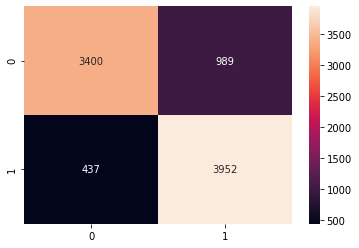

In [ ]:
sns.heatmap(array_for_hmap, annot=True, fmt = '1.0f') #최종 heatmap 그리기